In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
# from tqdm.auto import tqdm
from tqdm import tqdm
import pandas as pd
import torch
from IPython.display import HTML, display
from scipy import stats
import itertools
import time
from scipy.stats import ttest_ind
import os

# use cpu for smaller population and problem size
device = torch.device('cpu')
device

device(type='cpu')

In [2]:
student_id = 21522188

# Objective Functions

In [3]:
def f1(pop):
    """Sphere Function"""
    return (pop**2).sum(-1)


def f2(pop):
    "Griewank Function"
    pop_size, d = pop.shape

    sum1 = (pop**2).sum(-1) / 4000

    sqrt_indices = (
        torch.sqrt(torch.arange(1, d + 1, device=pop.device))
        .unsqueeze(0)
        .expand((pop_size, d))
    )

    cos1 = torch.cos(pop / sqrt_indices).prod(-1)

    return sum1 - cos1 + 1


def f3(pop):
    """Rosenbrock Function"""

    pop0 = pop[:, :-1]
    pop1 = pop[:, 1:]

    return (100 * ((pop1 - pop0**2) ** 2) + (pop0 - 1) ** 2).sum(-1)


def f4(pop, m=10):
    """Michalewicz Function"""
    pop_size, d = pop.shape

    indices = (
        torch.arange(1, d + 1, device=pop.device).unsqueeze(0).expand((pop_size, d))
    )

    sin1 = torch.sin(indices * (pop**2) / np.pi) ** (2 * m)

    return -(torch.sin(pop) * sin1).sum(-1)


def f5(pop, a=20, b=0.2, c=2 * np.pi):
    """Ackley Function"""
    pop_size, d = pop.shape

    exp_mean_cos = torch.exp(torch.cos(pop * c).sum(-1) / d)

    exp_sqrt_mean_square = torch.exp(torch.sqrt((pop**2).sum(-1) / d) * (-b))

    return exp_sqrt_mean_square * (-a) - exp_mean_cos + a + np.e


objectives = [
    {
        "name": "Sphere Function",
        "domain": [-5.12, 5.12],
        "g_optimum_d2": [0, 0],
        "func": f1,
    },
    {
        "name": "Griewank Function",
        "domain": [-600, 600],
        "g_optimum_d2": [0, 0],
        "func": f2,
    },
    {
        "name": "Rosenbrock Function",
        "domain": [-5, 10],
        "g_optimum_d2": [1, 1],
        "func": f3,
    },
    {
        "name": "Michalewicz Function",
        "domain": [0, np.pi],
        "g_optimum_d2": [2.2, 1.57],
        "func": f4,
    },
    {
        "name": "Ackley Function",
        "domain": [-32.768, 32.768],
        "g_optimum_d2": [0, 0],
        "func": f5,
    },
]

# differential evolution

In [4]:
def prepair_pop(pop, low, high):
    # prepair individuals that are out of domain
    # taken from https://doi.org/10.1016/j.swevo.2018.10.004
    _, d = pop.shape

    # pop = torch.where(pop > high, low - high + pop, pop)
    # pop = torch.where(pop < low, high - low + pop, pop)

    pop = torch.where(pop > high, 2*high - pop, pop)
    pop = torch.where(pop < low, 2*low - pop, pop)

    # pop = torch.where(pop > high, high, pop)
    # pop = torch.where(pop < low, low, pop)

    return pop


def initialize_population(num_individuals, d, low=0, high=1, device="cpu"):
    pop = (
        torch.distributions.uniform.Uniform(low, high)
        .sample((num_individuals, d))
        .to(device)
    )
    return pop


def create_mutant_pop(pop, F=0.1):
    pop_size, d = pop.shape

    # sample 3 indices from {0,1,2,...,N-1} / {i}
    uniform_dis = torch.ones((pop_size, pop_size - 1), device=pop.device)

    r = uniform_dis.multinomial(num_samples=3, replacement=False)

    r = torch.where(
        r >= torch.arange(pop_size, device=pop.device).unsqueeze(1), r + 1, r
    ).T

    V = pop[r[0]] + F * (pop[r[1]] - pop[r[2]])

    return V


def create_trial_pop(pop, Cr, F=0.1):
    pop_size, d = pop.shape

    # to ensure that offspring is different to their parent
    Jrand = torch.randint(d, size=(pop_size,), device=pop.device)

    # convert to the actual indices after flatten
    Jrand += torch.arange(pop_size, device=pop.device) * d

    condition = (torch.rand((pop_size, d), device=pop.device) <= Cr).flatten()

    condition[Jrand] = True

    condition = condition.reshape((pop_size, d))

    V = create_mutant_pop(pop, F)

    U = torch.where(condition, V, pop)

    return U


def de_selection(pop, trial_pop, pop_fitness, trial_pop_fitness):
    selected = trial_pop_fitness < pop_fitness

    new_pop = torch.where(selected.unsqueeze(1).expand_as(pop), trial_pop, pop)
    new_fitness = torch.where(selected, trial_pop_fitness, pop_fitness)

    return new_pop, new_fitness


def differential_evolution(
    objective=objectives[0],
    N=16,
    d=2,
    Cr=0.2,
    F=0.35,
    max_evaluations=None,
    seed=49,
    device="cpu",
    log_all=False,
):
    torch.manual_seed(seed)

    if max_evaluations is None:
        max_evaluations = d * 10000

    low, high = objective["domain"]

    pop = initialize_population(
        num_individuals=N,
        d=d,
        low=low,
        high=high,
        device=device,
    )
    pop_fitness = objective["func"](pop)
    num_evaluations = N

    generation_log = []

    while num_evaluations < max_evaluations:
        best_idv = pop_fitness.argmin()

        log = [
            num_evaluations,
            pop_fitness[best_idv].cpu().item(),
            pop[best_idv].cpu().tolist(),
        ]

        if log_all:
            log.append(pop.cpu().tolist())

        generation_log.append(log)

        # create trial population
        trial_pop = create_trial_pop(pop=pop, Cr=Cr, F=F)

        trial_pop = prepair_pop(trial_pop, low, high)

        trial_pop_fitness = objective["func"](trial_pop)
        num_evaluations += N

        pop, pop_fitness = de_selection(pop, trial_pop, pop_fitness, trial_pop_fitness)

    best_idv = pop_fitness.argmax()

    log = [
        num_evaluations,
        pop_fitness[best_idv].cpu().item(),
        pop[best_idv].cpu().tolist(),
    ]

    if log_all:
        log.append(pop.cpu().tolist())

    generation_log.append(log)

    return generation_log

# Cross-entropy method

In [5]:
def sample_search_points(u, cov, N):
    sampler = torch.distributions.multivariate_normal.MultivariateNormal(u, cov)
    return sampler.sample((N,))


def calc_cov(samples, u, e, W):
    # Wi = 1/Ne
    d = u.shape[0]

    u = u.unsqueeze(0).expand_as(samples)
    diff = samples - u

    return (
        torch.einsum("i,ij,ik->jk", W, diff, diff)
        + torch.eye(d, device=samples.device) * e
    )


def CEM(
    objective=objectives[0],
    o_init=None,
    u=None,
    e=1e-4,
    N=16,
    Ne=None,
    d=2,
    max_evaluations=None,
    seed=49,
    device="cpu",
    log_all=False,
):
    torch.manual_seed(seed)

    if max_evaluations is None:
        max_evaluations = d * 10000

    low, high = objective["domain"]

    if o_init is None:
        if objective["name"] == "Sphere Function":
            o_init = 0.2
            e = 1e-5
        elif objective["name"] == "Griewank Function":
            o_init = 1
            e = 0.1
        elif objective["name"] == "Rosenbrock Function":
            o_init = 20
            e = 5e-4
        elif objective["name"] == "Michalewicz Function":
            o_init = 1
            e = 3e-5
        elif objective["name"] == "Ackley Function":
            o_init = 30
            e = 0.08
        else:
            o_init = (high - low) * 2
            e = 1e-5 * (high - low)

    cov = torch.eye(d, device=device) * o_init

    if u == None:
        # randomly generate the mean within domain
        u = torch.distributions.uniform.Uniform(low, high).sample((d,))

    else:
        u = u.to(device)
    if Ne == None:
        Ne = N // 2

    num_evaluations = 0

    generation_log = []

    indices = torch.arange(Ne) + 1
    W = np.log(Ne + 1) - torch.log(indices)
    W = W / W.sum()

    while num_evaluations < max_evaluations:

        samples = sample_search_points(u, cov, N)

        # fix sample that are out of domain
        samples = prepair_pop(samples, low, high)

        samples_fitness = objective["func"](samples)
        num_evaluations += len(samples)

        topNe_ids = torch.topk(samples_fitness, k=Ne, largest=False).indices

        topNe = samples[topNe_ids]

        cov = calc_cov(topNe, u, e, W)

        u = torch.einsum("k,ki->i", W, topNe)

        best_idv = topNe_ids[0]
        log = [
            num_evaluations,
            samples_fitness[best_idv].cpu().item(),
            samples[best_idv].cpu().tolist(),
        ]

        if log_all:
            log.append(samples.cpu().tolist())

        generation_log.append(log)

    return generation_log

# experiments

In [6]:
def run_multiple(
    objective=objectives[0],
    d=10,
    N=16,
    max_evaluations=None,
    n_trials=10,
    init_seed=student_id,
    ge_func=differential_evolution,
    **func_args,
):
    ge_logs = []
    for i in tqdm(range(n_trials), leave=False):
        ge_log = ge_func(
            objective=objective,
            d=d,
            N=N,
            seed=init_seed + i,
            max_evaluations=max_evaluations,
            **func_args,
        )

        ge_logs.append(ge_log)

    return ge_logs

In [7]:
D = [2, 10]
N = [16, 32, 64, 128, 256]

jobs = [_ for _ in itertools.product(objectives, N, D)]

In [8]:
%%time

try:
    results
except NameError:
    results = {"DE": {}, "CEM": {}}

for obj, n, d in (pbar := tqdm(jobs)):
    if obj["name"] not in results["DE"].keys():
        results["DE"][obj["name"]] = {}
        results["CEM"][obj["name"]] = {}

    if n not in results["DE"][obj["name"]].keys():
        results["DE"][obj["name"]][n] = {}
        results["CEM"][obj["name"]][n] = {}

    pbar.set_description(f"running DE on {obj['name']} with dim={d} and N={n}")

    result = run_multiple(
        objective=obj, d=d, N=n, init_seed=student_id, ge_func=differential_evolution
    )
    results["DE"][obj["name"]][n][d] = result

np.save("results.npy", results)

running DE on Ackley Function with dim=10 and N=256: 100%|██████████| 50/50 [03:53<00:00,  4.67s/it]     


CPU times: user 14min 33s, sys: 2.3 s, total: 14min 35s
Wall time: 3min 54s


In [9]:
%%time

for obj, n, d in (pbar := tqdm(jobs)):
    
    pbar.set_description(f"running CEM on {obj['name']} with dim={d} and N={n}")
    result = run_multiple(
        objective=obj,
        d=d,
        N=n,
        init_seed=student_id,
        ge_func=CEM,
    )
    results["CEM"][obj["name"]][n][d] = result

np.save("results.npy", results)

running CEM on Ackley Function with dim=10 and N=256: 100%|██████████| 50/50 [06:10<00:00,  7.42s/it]     


CPU times: user 36min 42s, sys: 3.43 s, total: 36min 45s
Wall time: 6min 12s


# t-test

In [10]:
# vì file results.npy rất lớn nên em không nộp được
results = np.load("results.npy", allow_pickle=True).tolist()

In [12]:
with open("output.csv", "w") as csv_output:
    for obj in objectives:
        obj_name = obj["name"]
        for d in D:

            csv_output.write(f"{obj_name} with dim={d}\n")
            csv_output.write(f"N, DE, CEM, p_value\n")
            for n in N:

                de_res = results["DE"][obj_name][n][d]
                cem_res = results["CEM"][obj_name][n][d]

                de_x = [l[0] for l in de_res[0]]
                cem_x = [l[0] for l in cem_res[0]]

                assert de_x == cem_x

                # 10, len(de_x)
                # best fitness for each seed
                de_y = np.array([[l[1] for l in t] for t in de_res]).min(1)
                cem_y = np.array([[l[1] for l in t] for t in cem_res]).min(1)

                de_y_mean = de_y.mean()
                de_y_std = de_y.std()

                cem_y_mean = cem_y.mean()
                cem_y_std = cem_y.std()

                pvalue = ttest_ind(de_y, cem_y).pvalue

                # print("DE: ", de_y_mean, de_y_std)
                # print("CEM: ", cem_y_mean, cem_y_std)
                # print(pvalue)

                de_y_mean = round(de_y_mean,5)
                de_y_std = round(de_y_std,5)
                cem_y_mean = round(cem_y_mean,5)
                cem_y_std = round(cem_y_std,5)
                pvalue = round(pvalue,4)

                # de_y_mean = np.format_float_scientific(de_y_mean, precision=1)
                # de_y_std = np.format_float_scientific(de_y_mean, precision=1)
                # cem_y_mean = np.format_float_scientific(de_y_mean, precision=1)
                # cem_y_std = np.format_float_scientific(de_y_mean, precision=1)
                # pvalue = np.format_float_scientific(de_y_mean, precision=1)

                csv_output.write(
                    f"{n}, {de_y_mean}({de_y_std}), {cem_y_mean}({cem_y_std}), {pvalue}\n"
                )

            csv_output.write("\n")

# convergence graphs

In [15]:
results = np.load("results.npy", allow_pickle=True).tolist()

In [16]:
def plot_convergence_graph(results, obj_name="Sphere Function", N=16, d=2):
    de_res = results["DE"][obj_name][N][d]
    cem_res = results["CEM"][obj_name][N][d]

    de_x = [l[0] for l in de_res[0]]
    cem_x = [l[0] for l in cem_res[0]]

    assert de_x == cem_x

    # len(de_x), 10
    de_y = np.array([[l[1] for l in t] for t in de_res]).T
    cem_y = np.array([[l[1] for l in t] for t in cem_res]).T

    de_y_mean = de_y.mean(1)
    de_y_std = de_y.std(1)

    cem_y_mean = cem_y.mean(1)
    cem_y_std = cem_y.std(1)

    fig, ax = plt.subplots()
    ax.plot(de_x, de_y_mean, "-", label=f"DE-{N}", color="tab:red")
    ax.fill_between(
        de_x, de_y_mean - de_y_std, de_y_mean + de_y_std, alpha=0.2, color="tab:red"
    )
    ax.plot(de_x, de_y_mean, "o", color="tab:red", ms=3)

    ax.plot(cem_x, cem_y_mean, "-", label=f"CEM-{N}", color="tab:blue")
    ax.fill_between(
        cem_x,
        cem_y_mean - cem_y_std,
        cem_y_mean + cem_y_std,
        alpha=0.2,
        color="tab:blue",
    )
    ax.plot(cem_x, cem_y_mean, "o", color="tab:blue", ms=3)

    plt.title(f"{obj_name} with d={d}")
    plt.xlabel("Number of fitness evaluations")
    plt.ylabel("Objective function value")
    plt.legend()
    plt.show()

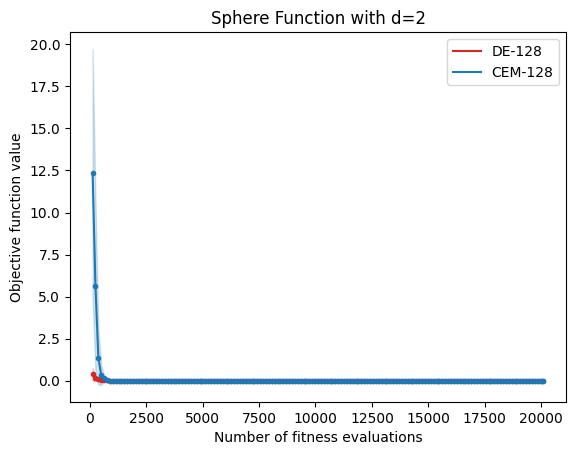

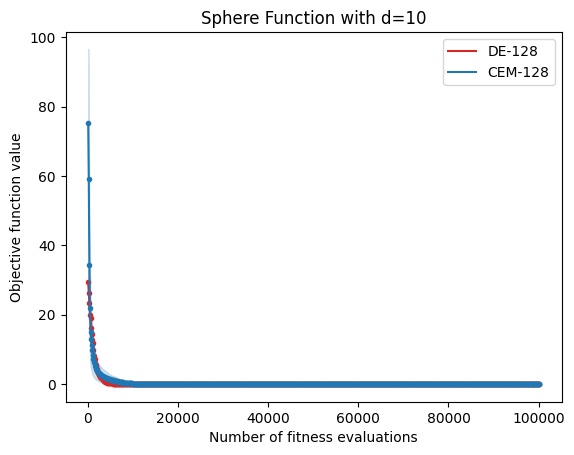

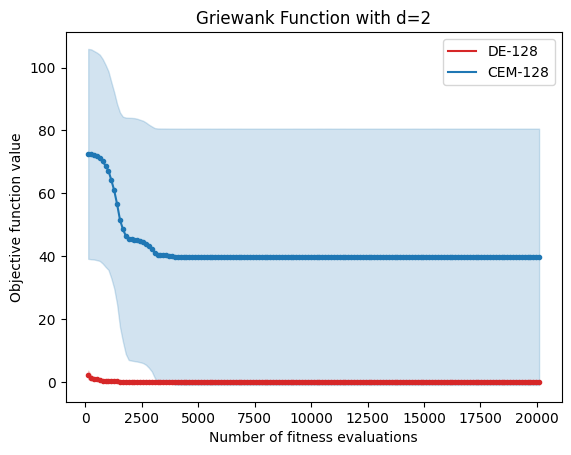

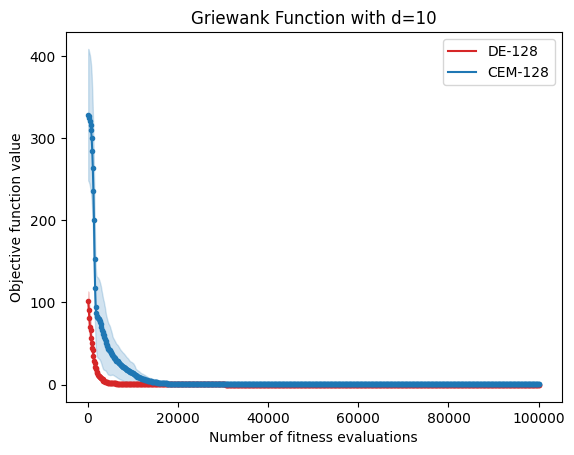

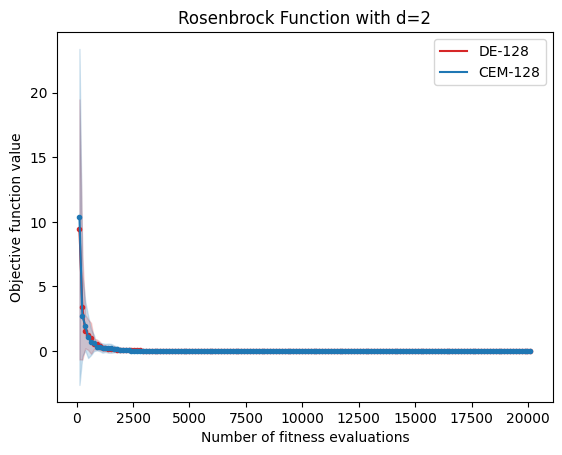

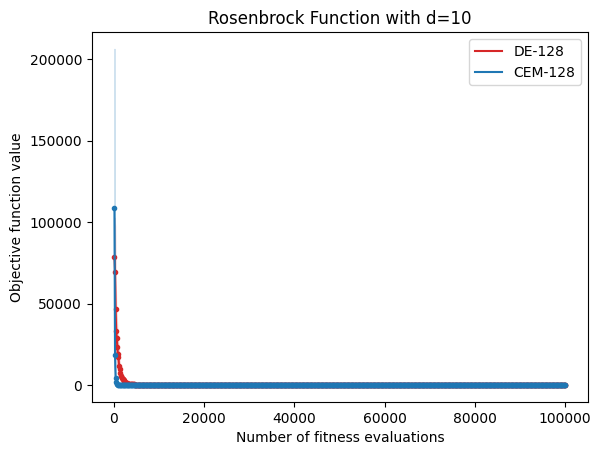

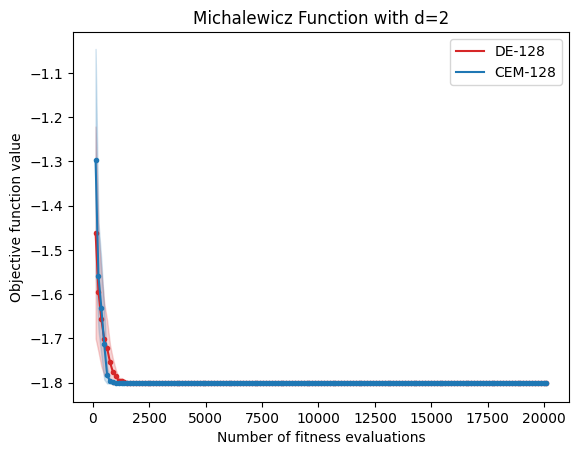

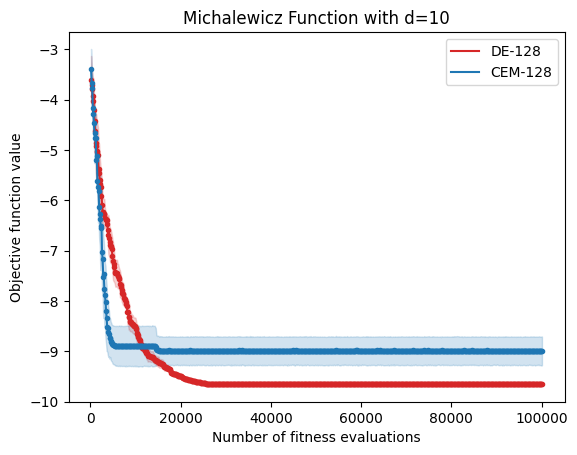

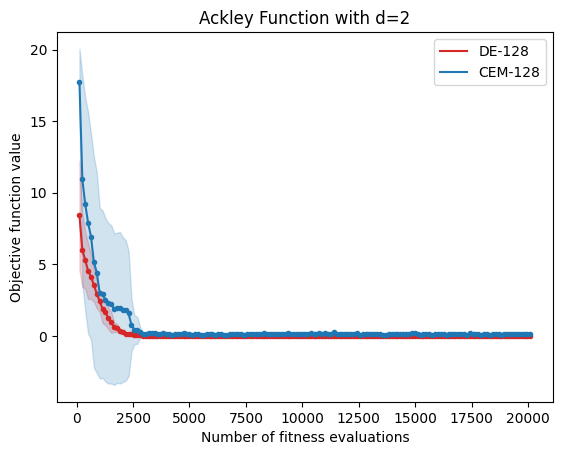

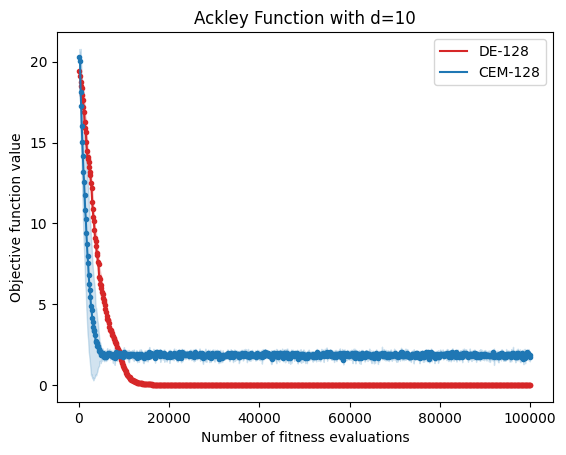

In [21]:
for obj in objectives:
    obj_name = obj["name"]
    for d in D:
        for n in [128]:
            plot_convergence_graph(results, obj_name=obj_name, N=n, d=d)

# animations

In [18]:
def draw_contour_optimum(objective=objectives[0], plt=plt):
    low, high = objective["domain"]
    opti_x, opti_y = objective["g_optimum_d2"]

    x = np.linspace(low, high, 100)
    y = np.linspace(low, high, 100)

    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.flatten(), yv.flatten()]).T

    xy = torch.tensor(xy)
    z = objective["func"](xy).numpy().reshape(xv.shape)

    plt.contourf(x, y, z)
    plt.scatter(opti_x, opti_y, c="r")


def update(i, pops, scat):
    pop = np.array(pops[i])

    scat.set_offsets(pop)
    return scat


def animate(
    objective=objectives[0],
    use_DE=True,
    seed=student_id,
    N=16,
    frames=50,
    interval=100,
    **func_args,
):
    if use_DE:
        result = differential_evolution(
            objective=objective, d=2, N=N, seed=seed, log_all=True, **func_args
        )
        func_name = "DE"
    else:
        result = CEM(
            objective=objective, d=2, N=N, seed=seed, log_all=True, **func_args
        )
        func_name = "CEM"

    pops = [r[3] for r in result]

    fig, ax = plt.subplots()

    plt.title(f"{func_name} on {objective['name']} with d=2 and N={N}")

    draw_contour_optimum(objective=objective, plt=ax)
    scat = ax.scatter([], [], c="w", s=2)

    ani = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval, fargs=(pops, scat)
    )

    plt.close()
    return ani

if not os.path.isdir("./gifs"):
   os.makedirs("./gifs")


In [ ]:
# DE
# 
for obj in objectives:
    ani = animate(objective=obj, use_DE=True, frames=100, N=32)
    h = HTML(ani.to_jshtml())
    ani.save(f"./gifs/DE {obj['name']}.gif")
    display(h)

In [ ]:
# CEM
for obj in objectives:
    ani = animate(objective=obj, use_DE=False, frames=150, N=32)
    h = HTML(ani.to_jshtml())
    ani.save(f"./gifs/CEM {obj['name']}.gif")
    display(h)
